In [238]:

import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
import torch
import numpy as np
import pandas as pd
import json
import matplotlib.patches as mpatches

from matplotlib import cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

#plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [239]:

print(dico_config)

{'NoNoise': {'param': [0], 'lr_svi': 0.01}, 'Blurring': {'param': [1, 2, 3, 4], 'lr_svi': 0.001}, 'WhiteNoise': {'param': [0.2, 0.4, 0.6, 0.8, 1], 'lr_svi': 0.01}, 'SaltPepper': {'param': [0.1, 0.2, 0.3, 0.4], 'lr_svi': 0.01}}


In [240]:
## TO DO
## 1 - normalize the image for Gaussian filtering
## 2 - Do the CNN baseline
## 3 - Do a bar graph for beta
## 4 - Try with a l2 loss decoder (i.e. gaussian input)
## 5 - Try with a Gaussian mixture prior

dict_keys(['NoNoise', 'Blurring', 'WhiteNoise', 'SaltPepper'])
/media/data_cifs_lrs/projects/prj_predcoding/prj_probcod_exps/2020-09-29_08-36-35_EVAL_CL/result_WhiteNoise_0.2.pth


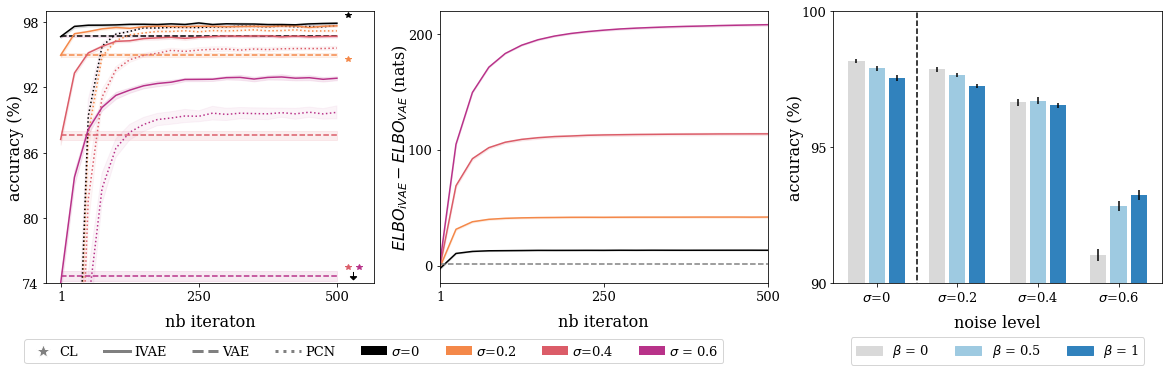

In [325]:

base_path = '/media/data_cifs_lrs/projects/prj_predcoding/'
path_EVAL_DB = base_path + 'db_EVAL_3.csv'
# path_TRAIN_DB = '../db_TRAIN.csv'

EVAL_db = pd.read_csv(path_EVAL_DB, index_col=0)
# TRAIN_db = pd.read_csv(path_TRAIN_DB, index_col=0)

#print(EVAL_db)

with open(base_path + 'config_eval.json') as config_file:
    dico_config = json.load(config_file)
    
    
cmap = plt.get_cmap('plasma')
x = np.linspace(0.0, 1.0, 8)
# rgb = cm.get_cmap(plt.get_cmap('plasma'))(x)
color_list = cm.get_cmap(plt.get_cmap('plasma'))(x)
color_list = list(reversed(color_list[:6]))
# color_list = ['darkblue','slateblue', 'green', 'purple','red', 'orange']

text_size = 13
y_lim_inf = 74
beta = 1

fig, ax = plt.subplots(1, 3 ,figsize=(20,5))

nb_it = 500.0
zdim = 15.0
#svi_lr_eval = 5e-3
list_it = np.arange(0,501,25)
print(dico_config.keys())

### CURVE 1
idx_graph = 0
plots = {}
my_noise_list = ['NoNoise', 'WhiteNoise']
my_param_list = [0.2,0.4,0.6]
for noise_type in my_noise_list:
    if noise_type != 'NoNoise':
        idx_inf = 20
        for idx_param, param in enumerate(my_param_list):
            model_type = 'CL'
            out_CL = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                         (EVAL_db['transform'] == noise_type) & \
                         (EVAL_db['normalize_output'] == 1.0) & \
                         (EVAL_db['param'] == param), 'path_to_results'].values[0]
            
            if idx_param==0:
                print(out_CL)
            accu_CL = torch.load(  out_CL)['accuracy']
            accu_CL = accu_CL.cpu().numpy()
            

            if accu_CL < y_lim_inf :

                accu_CL = y_lim_inf+1.5

                position_x = list_it[-1] + idx_inf
                idx_inf += 20
            else : 
                position_x = list_it[-1] + idx_inf
            ax[0].plot(position_x, accu_CL, '*', color=color_list[idx_param], label=r'CL - $\sigma$={}'.format(param))
            
        ## baseline classifier
        model_type = 'CL'
        out_CL = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
             (EVAL_db['transform'] == 'NoNoise') & \
             (EVAL_db['normalize_output'] == 1.0), 'path_to_results'].values[0]
        accu_CL = torch.load(  out_CL)['accuracy']
        accu_CL = accu_CL.cpu().numpy()
        
        #accu_CL = 100-accu_CL
        
        ax[0].plot(list_it[-1]+20, accu_CL, '*', color='black', label=r'CL - NoNoise'.format(param))
        for idx_param, param in enumerate(my_param_list):
        #for idx_param, param in enumerate(dico_config[noise_type]['param']):
            model_type = 'VAE'
            out_VAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                     (EVAL_db['model_z_dim'] == zdim) & \
                     (EVAL_db['beta'] == beta) & \
                     (EVAL_db['transform'] == noise_type) & \
                     (EVAL_db['normalize_output'] == 1.0) & \
                     #(EVAL_db['svi_nb_it_eval'] == nb_it) & \
                     (EVAL_db['param'] == param), 
                                  'path_to_results'].values
            
            accu_VAE = np.stack([torch.load(
                file)['accuracy'] for file in out_VAE], 0)
            #accu_VAE = 100 - accu_VAE
            accu_VAE_mean = accu_VAE.mean(0)
            accu_VAE_std = accu_VAE.std(0)
            x = [list_it[0],list_it[-1]]
            y = np.array([accu_VAE_mean, accu_VAE_mean])

            ax[0].plot(x, y, '--', color=color_list[idx_param], label=r'VAE - $\sigma$={}'.format(param))
            ax[0].fill_between(x, (y-accu_VAE_std), (y+accu_VAE_std), color=color_list[idx_param], alpha=.1)
            
        ## baseline VAE
        model_type = 'VAE'
        out_VAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
             (EVAL_db['model_z_dim'] == zdim) & \
             (EVAL_db['beta'] == beta) & \
             (EVAL_db['transform'] == 'NoNoise') & \
             (EVAL_db['normalize_output'] == 1.0),
             #(EVAL_db['svi_nb_it_eval'] == nb_it) & \ 
                          'path_to_results'].values

        accu_VAE = np.stack([torch.load(
            file)['accuracy'] for file in out_VAE], 0)
        #accu_VAE = 100- accu_VAE
        accu_VAE_mean = accu_VAE.mean(0)
        accu_VAE_std = accu_VAE.std(0)
        x = [list_it[0],list_it[-1]]
        y = np.array([accu_VAE_mean, accu_VAE_mean])

        ax[0].plot(x, y, '--', color='black', label=r'VAE - NoNoise')
        ax[0].fill_between(x, (y-accu_VAE_std), (y+accu_VAE_std), color=color_list[idx_param], alpha=.1)
        
        #for idx_param, param in enumerate(dico_config[noise_type]['param']):
        for idx_param, param in enumerate(my_param_list):
            model_type = 'PCN'

            out_PCN = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                     (EVAL_db['model_z_dim'] == zdim) & \
                     (EVAL_db['beta'] == beta) & \
                     (EVAL_db['transform'] == noise_type) & \
                     (EVAL_db['normalize_output'] == 1.0) & \
                     (EVAL_db['svi_nb_it_eval'] == nb_it) & \
                     (EVAL_db['param'] == param), 'path_to_results'].values
            
            accu_PCN = np.stack([torch.load(
                file)['accuracy'] for file in out_PCN], 0)
            #accu_PCN = 100-accu_PCN
            accu_PCN_mean = accu_PCN.mean(0)
            accu_PCN_std = accu_PCN.std(0)
            
            x = list_it
            y = np.array(accu_PCN_mean)
            
            ax[0].plot(x, y, ':', color=color_list[idx_param], alpha=1.0, label=r'PCN - $\sigma$={}'.format(param))
            ax[0].fill_between(x, (y-accu_PCN_std), (y+accu_PCN_std), color=color_list[idx_param], alpha=.05)
            
        ## baseline PCN
        model_type = 'PCN'

        out_PCN = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                 (EVAL_db['model_z_dim'] == zdim) & \
                 (EVAL_db['beta'] == beta) & \
                 (EVAL_db['transform'] == 'NoNoise') & \
                 (EVAL_db['normalize_output'] == 1.0) & \
                 (EVAL_db['svi_nb_it_eval'] == nb_it), 'path_to_results'].values
        
        accu_PCN = np.stack([torch.load(file)['accuracy'] for file in out_PCN], 0)
        accu_PCN_mean = accu_PCN.mean(0)
        accu_PCN_std = accu_PCN.std(0)

        x = list_it
        y = np.array(accu_PCN_mean)
        
        ax[0].plot(x, y, ':', color='black', alpha=1.0, label=r'PCN - NoNoise')
        ax[0].fill_between(x, (y-accu_PCN_std), (y+accu_PCN_std), color=color_list[idx_param], alpha=.05)

        for idx_param, param in enumerate(my_param_list):
            model_type = 'IVAE'
            #print(dico_config[noise_type]['lr_svi'])
            out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                     (EVAL_db['model_z_dim'] == zdim) & \
                     (EVAL_db['beta'] == beta) & \
                     (EVAL_db['transform'] == noise_type) & \
                     (EVAL_db['normalize_output'] == 1.0) & \
                     (EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                     (EVAL_db['svi_nb_it_eval'] == nb_it) & \
                     (EVAL_db['param'] == param), 'path_to_results'].values

            accu_IVAE = np.stack([torch.load(
                file)['accuracy'] for file in out_IVAE], 0)
            #accu_IVAE = 100-accu_IVAE
            accu_IVAE_mean = accu_IVAE.mean(0)
            accu_IVAE_std = accu_IVAE.std(0)
            x = list_it
            y = np.array(accu_IVAE_mean)
            

            ax[0].plot(x, y, color=color_list[idx_param], label=r'IVAE - $\sigma$={}'.format(param))
            ax[0].fill_between(x, (y-accu_IVAE_std), (y+accu_IVAE_std), color=color_list[idx_param], alpha=.1)
            
        ## baseline IVAE
        model_type = 'IVAE'

        out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                 (EVAL_db['model_z_dim'] == zdim) & \
                 (EVAL_db['beta'] == beta) & \
                 (EVAL_db['transform'] == 'NoNoise') & \
                 (EVAL_db['normalize_output'] == 1.0) & \
                 (EVAL_db['svi_nb_it_eval'] == nb_it), 'path_to_results'].values

        accu_IVAE = np.stack([torch.load(file)['accuracy'] for file in out_IVAE], 0)
        
        accu_IVAE_mean = accu_IVAE.mean(0)
        accu_IVAE_std = accu_IVAE.std(0)
        x = list_it
        y = np.array(accu_IVAE_mean)

        ax[0].plot(x, y, color='black', label=r'IVAE - $\sigma$={}'.format(param))
        ax[0].fill_between(x, (y-accu_IVAE_std), (y+accu_IVAE_std), color='black', alpha=.1)
        ax[0].set_yticks([74,80,86,92, 98])
        ax[0].set_yticklabels(['74','80','86','92', '98'])
        ax[0].set_ylim(y_lim_inf,99)
        ax[0].set_xticklabels(['1','250','500'])
        ax[0].set_xticks([1,250,500])
        ax[0].tick_params(labelsize=text_size)
        
        idx_graph+=1    
    
        
# setting labels
ax[0].set_xlabel(r'nb iteraton', fontsize=16, labelpad=10)
ax[0].set_ylabel(r'accuracy (%)', fontsize=16, labelpad=-2)
ax[0].arrow(530,y_lim_inf+1.,0,-0.4,head_width=12, head_length=0.3, fc='k', ec='k')


## SECOND CURVE


path_EVAL_DB = base_path + 'db_EVAL_4.csv'
EVAL_db = pd.read_csv(path_EVAL_DB, index_col=0)
with open(base_path + 'config_eval.json') as config_file:
    dico_config = json.load(config_file)

cmap = plt.get_cmap('plasma')
#x = np.linspace(0.0, 1.0, 8)
# rgb = cm.get_cmap(plt.get_cmap('plasma'))(x)
#color_list = cm.get_cmap(plt.get_cmap('plasma'))(x)
#color_list = list(reversed(color_list[:6]))
# color_list = ['darkblue','slateblue', 'green', 'purple','red', 'orange']

#text_size = 13
#y_lim_inf = 72
#beta = 1

#fig, ax = plt.subplots(1, 1 ,figsize=(4,5))
#nb_it = 500.0
#zdim = 15.0
#svi_lr_eval = 5e-3
#list_it = np.arange(0,501,25)
#print(dico_config.keys())

idx_graph = 0
#plots = {}
#my_noise_list = ['NoNoise', 'WhiteNoise']
#my_param_list = [0.2,0.4,0.6,0.8,1]
#for noise_type in dico_config.keys():
for noise_type in my_noise_list:
    if noise_type != 'NoNoise':
        idx_inf = 10

        for idx_param, param in enumerate(my_param_list):
            model_type = 'VAE'
            out_VAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                     (EVAL_db['model_z_dim'] == zdim) & \
                     (EVAL_db['beta'] == beta) & \
                     (EVAL_db['transform'] == noise_type) & \
                     (EVAL_db['normalize_output'] == 1.0) & \
                     #(EVAL_db['svi_nb_it_eval'] == nb_it) & \
                     (EVAL_db['param'] == param), 
                                  'path_to_results'].values
            
        
            ELBO_VAE = np.stack([torch.load(
                file)['ELBO'] for file in out_VAE], 0)
            
            ELBO_VAE = ELBO_VAE.mean(1) 
            
            model_type = 'IVAE'
            out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                     (EVAL_db['model_z_dim'] == zdim) & \
                     (EVAL_db['beta'] == beta) & \
                     (EVAL_db['transform'] == noise_type) & \
                     (EVAL_db['normalize_output'] == 1.0) & \
                     (EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                     (EVAL_db['svi_nb_it_eval'] == nb_it) & \
                     (EVAL_db['param'] == param), 'path_to_results'].values

            ELBO_IVAE = np.stack([torch.load(
                file)['ELBO'] for file in out_IVAE], 0)
            ELBO_IVAE = ELBO_IVAE.mean(1) 
            rel_ELBO_IVAE = -ELBO_IVAE + ELBO_VAE[:,None]
            ELBO_IVAE_mean = rel_ELBO_IVAE.mean(0)
            ELBO_IVAE_std = rel_ELBO_IVAE.std(0)
            x = list_it
            y = np.array(ELBO_IVAE_mean)
            ax[1].plot(x, y, color=color_list[idx_param], label=r'IVAE - $\sigma$={}'.format(param))
            ax[1].fill_between(x, (y-ELBO_IVAE_std), (y+ELBO_IVAE_std), color=color_list[idx_param], alpha=.1)
            
        ## baseline VAE
        model_type = 'VAE'
        out_VAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
             (EVAL_db['model_z_dim'] == zdim) & \
             (EVAL_db['beta'] == beta) & \
             (EVAL_db['transform'] == 'NoNoise') & \
             (EVAL_db['normalize_output'] == 1.0),
                          'path_to_results'].values
        
        ELBO_VAE = np.stack([torch.load(
                file)['ELBO'] for file in out_VAE], 0)
        ELBO_VAE = ELBO_VAE.mean(1) 
        
        
        model_type = 'IVAE'
        

        out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                 (EVAL_db['model_z_dim'] == zdim) & \
                 (EVAL_db['beta'] == beta) & \
                 (EVAL_db['transform'] == 'NoNoise') & \
                 (EVAL_db['normalize_output'] == 1.0) & \
                 (EVAL_db['svi_nb_it_eval'] == nb_it), 'path_to_results'].values

        ELBO_IVAE = np.stack([torch.load(file)['ELBO'] for file in out_IVAE], 0)
        

        ELBO_IVAE = ELBO_IVAE.mean(1)
        rel_ELBO_IVAE = -ELBO_IVAE + ELBO_VAE[:,None]
        ELBO_IVAE_mean = rel_ELBO_IVAE.mean(0)
        ELBO_IVAE_std = rel_ELBO_IVAE.std(0)
        x = list_it
        y = np.array(ELBO_IVAE_mean)

        ax[1].plot(x, y, color='black', label=r'IVAE - $\sigma$={}'.format(param))
        ax[1].fill_between(x, (y-ELBO_IVAE_std), (y+ELBO_IVAE_std), color='black', alpha=.1)
        

        ax[1].tick_params(labelsize=text_size)
        
        ax[1].plot([list_it[0], list_it[-1]], [1,1], linestyle='--', color='grey')
        idx_graph+=1    

        ax[1].set_yticks([0,100,200])

        

        ax[1].set_yticklabels(['0','100','200'])
        ax[1].set_ylim=(0,250)
        ax[1].set_xticklabels(['1','250','500'])
        ax[1].set_xticks([1,250,500])
        ax[1].set_xlim(0,500)
# setting labels
ax[1].set_xlabel(r'nb iteraton', fontsize=16, labelpad=10)
ax[1].set_ylabel(r'$ELBO_{iVAE}-ELBO_{VAE}$ (nats)', fontsize=16, labelpad=-2)

### Third curve

path_EVAL_DB = base_path + 'db_EVAL_3.csv'
EVAL_db = pd.read_csv(path_EVAL_DB, index_col=0)

#text_size = 13
cmap = plt.cm.get_cmap('tab20c')
#all_color = [cmap.colors[19], cmap.colors[3], cmap.colors[2], cmap.colors[1], cmap.colors[0]]
all_color = [cmap.colors[19], cmap.colors[2], cmap.colors[0]]
#zdim=15.0
#beta_list = [0,0.5,1,1.5,2]
#nb_it = 500.0

#fig, ax = plt.subplots(1,1,figsize=(12,7))
#plt.tick_params(
#            axis='x',
#            which='both',
#            bottom=False,
#            top=False,
#            labelbottom=True)
i = 0
#print(dico_config.keys())
my_beta_list=[0,1,2]
idx_noise=-1

all_bars = []
#my_noise_list = ['NoNoise', 'WhiteNoise']
#my_param_list = [0.2,0.4,0.6]

for noise_type in my_noise_list:
    
    if noise_type != 'NoNoise':
        

        tick_position = [1,5,9,13]

        
        i=0
        for idx_beta, beta in enumerate(my_beta_list):
            model_type = 'IVAE'
            #print(dico_config[noise_type]['lr_svi'])
            out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                 (EVAL_db['model_z_dim'] == zdim) & \
                 (EVAL_db['beta'] == beta) & \
                 (EVAL_db['transform'] == 'NoNoise') & \
                 (EVAL_db['normalize_output'] == 1.0) & \
                 #(EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                 (EVAL_db['svi_nb_it_eval'] == nb_it), 'path_to_results'].values
            
            accu_VAE = np.stack([torch.load(
                file)['accuracy'] for file in out_IVAE], 0)

            accu_VAE_mean = accu_VAE.mean(0)
            accu_VAE_std = accu_VAE.std(0)
            
            bars = ax[2].bar(i, accu_VAE_mean[-1], color=all_color[idx_beta], bottom=0, label=r'$\beta$ = {0}'.format(beta), yerr=accu_VAE_std[-1])
            
            all_bars.append(bars)
            i=i+1
        i=i+0.5
        ax[2].vlines(i-0.5, 0,100, linestyles='dashed', color='black')
        i=i+0.5
        for idx_param, param in enumerate(my_param_list):
            for idx_beta, beta in enumerate(my_beta_list):
                model_type = 'IVAE'
                out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                         (EVAL_db['model_z_dim'] == zdim) & \
                         (EVAL_db['beta'] == beta) & \
                         (EVAL_db['transform'] == noise_type) & \
                         (EVAL_db['normalize_output'] == 1.0) & \
                         #(EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                         (EVAL_db['svi_nb_it_eval'] == nb_it) & \
                         (EVAL_db['param'] == param), 'path_to_results'].values
            
                accu_VAE = np.stack([torch.load(
                    file)['accuracy'] for file in out_IVAE], 0)

                accu_VAE_mean = accu_VAE.mean(0)
                accu_VAE_std = accu_VAE.std(0)
                bars = ax[2].bar(i, accu_VAE_mean[-1], color=all_color[idx_beta], bottom=0, label=r'$\beta$ = {0}'.format(beta), yerr=accu_VAE_std[-1])

                all_bars.append(bars)
                i = i+1
            i = i+1
        ax[2].set_xticks(tick_position)
        ax[2].set_xticklabels([r'$\sigma$=0']+ [r'$\sigma$={0}'.format(str(param)) for param in my_param_list ], fontsize=text_size)
        ax[2].tick_params(labelsize=text_size)

        
        ax[2].set_yticks([90,95,100])
        ax[2].set_yticklabels(['90','95','100'], fontsize=text_size)
        ax[2].set_ylim(90,100)
ax[2].set_xlabel('noise level', fontsize=16, labelpad=10)
ax[2].set_ylabel(r'accuracy (%)', fontsize=16, labelpad=-2)
        

## just for legend
patches = []
for idx_beta, color in enumerate(all_color):
    patches.append(mpatches.Patch(color=color, label=r'$\beta$ = {0}'.format(beta_list[idx_beta])))
out = ax[2].legend(handles=patches, fontsize=text_size, loc='center', bbox_to_anchor=(0.5,-0.25), ncol=5)





        
legend_elements = [Line2D([0], [0], marker='*', color='w', label='CL', markerfacecolor='grey', markersize=15),
                   Line2D([0], [0], linestyle='-',  color='grey', lw=3, label='IVAE'),
                   Line2D([0], [0], linestyle='--', color='grey', lw=3, label='VAE'),
                   Line2D([0], [0], linestyle=':',  color='grey', lw=3, label='PCN'),
                   Patch(facecolor='black',       label=r'$\sigma$=0'),
                   Patch(facecolor=color_list[0], label=r'$\sigma$=0.2'),
                   Patch(facecolor=color_list[1], label=r'$\sigma$=0.4'),
                   Patch(facecolor=color_list[2], label=r'$\sigma$ = 0.6'),
                   #Patch(facecolor=color_list[3], label=r'$\sigma$ = 0.8'),
                   #Patch(facecolor=color_list[4], label=r'$\sigma$ = 1')
                  ]

ax[0].legend(handles=legend_elements, loc='center', bbox_to_anchor=(1,-0.25), ncol=8, fontsize=text_size, handletextpad=0.3)


plt.savefig('plot_ML.pdf', bbox_inches='tight')



dict_keys(['NoNoise', 'Blurring', 'WhiteNoise', 'SaltPepper'])


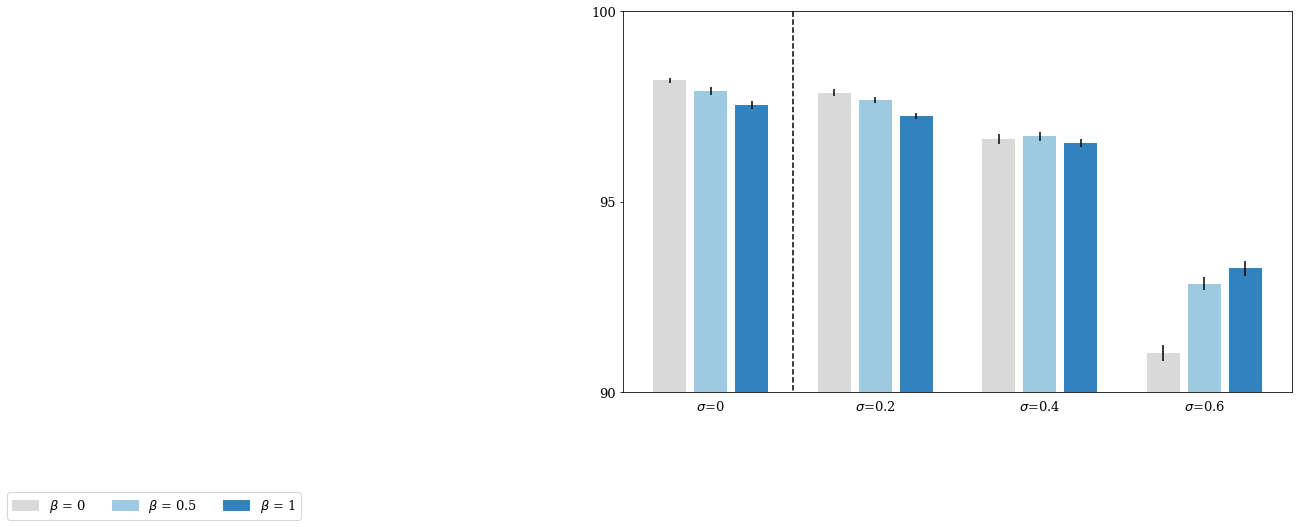

In [303]:
base_path = '/media/data_cifs_lrs/projects/prj_predcoding/'
path_EVAL_DB = base_path + 'db_EVAL_3.csv'
# path_TRAIN_DB = '../db_TRAIN.csv'

EVAL_db = pd.read_csv(path_EVAL_DB, index_col=0)

text_size = 13
cmap = plt.cm.get_cmap('tab20c')
#all_color = [cmap.colors[19], cmap.colors[3], cmap.colors[2], cmap.colors[1], cmap.colors[0]]
all_color = [cmap.colors[19], cmap.colors[2], cmap.colors[0]]
zdim=15.0
beta_list = [0,0.5,1,1.5,2]
nb_it = 500.0

fig, ax = plt.subplots(1,1,figsize=(12,7))
plt.tick_params(
            axis='x',
            which='both',
            bottom=False,
            top=False,
            labelbottom=True)
i = 0
print(dico_config.keys())
my_beta_list=[0,1,2]
idx_noise=-1

all_bars = []
my_noise_list = ['NoNoise', 'WhiteNoise']
my_param_list = [0.2,0.4,0.6]

for noise_type in my_noise_list:
    
    if noise_type != 'NoNoise':
        

        tick_position = [1,5,9,13]

        
        i=0
        for idx_beta, beta in enumerate(my_beta_list):
            model_type = 'IVAE'
            #print(dico_config[noise_type]['lr_svi'])
            out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                 (EVAL_db['model_z_dim'] == zdim) & \
                 (EVAL_db['beta'] == beta) & \
                 (EVAL_db['transform'] == 'NoNoise') & \
                 (EVAL_db['normalize_output'] == 1.0) & \
                 #(EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                 (EVAL_db['svi_nb_it_eval'] == nb_it), 'path_to_results'].values
            
            accu_VAE = np.stack([torch.load(
                file)['accuracy'] for file in out_IVAE], 0)

            accu_VAE_mean = accu_VAE.mean(0)
            accu_VAE_std = accu_VAE.std(0)
            
            bars = ax.bar(i, accu_VAE_mean[-1], color=all_color[idx_beta], bottom=0, label=r'$\beta$ = {0}'.format(beta), yerr=accu_VAE_std[-1])
            
            all_bars.append(bars)
            i=i+1
        i=i+0.5
        ax.vlines(i-0.5, 0,100, linestyles='dashed', color='black')
        i=i+0.5
        for idx_param, param in enumerate(my_param_list):
            for idx_beta, beta in enumerate(my_beta_list):
                model_type = 'IVAE'
                out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                         (EVAL_db['model_z_dim'] == zdim) & \
                         (EVAL_db['beta'] == beta) & \
                         (EVAL_db['transform'] == noise_type) & \
                         (EVAL_db['normalize_output'] == 1.0) & \
                         #(EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                         (EVAL_db['svi_nb_it_eval'] == nb_it) & \
                         (EVAL_db['param'] == param), 'path_to_results'].values
            
                accu_VAE = np.stack([torch.load(
                    file)['accuracy'] for file in out_IVAE], 0)

                accu_VAE_mean = accu_VAE.mean(0)
                accu_VAE_std = accu_VAE.std(0)
                bars = ax.bar(i, accu_VAE_mean[-1], color=all_color[idx_beta], bottom=0, label=r'$\beta$ = {0}'.format(beta), yerr=accu_VAE_std[-1])

                all_bars.append(bars)
                i = i+1
            i = i+1
        ax.set_xticks(tick_position)
        ax.set_xticklabels([r'$\sigma$=0']+ [r'$\sigma$={0}'.format(str(param)) for param in my_param_list ], fontsize=text_size)
        ax.tick_params(labelsize=text_size)

        
        ax.set_yticks([90,95,100])
        ax.set_yticklabels(['90','95','100'], fontsize=text_size)
        ax.set_ylim(90,100)
        

## just for legend
patches = []
for idx_beta, color in enumerate(all_color):
    patches.append(mpatches.Patch(color=color, label=r'$\beta$ = {0}'.format(beta_list[idx_beta])))
out = plt.legend(handles=patches, fontsize=text_size, loc='center', bbox_to_anchor=(-0.7,-0.3), ncol=5)




In [258]:

cmap = plt.get_cmap('plasma')
x = np.linspace(0.0, 1.0, 8)
# rgb = cm.get_cmap(plt.get_cmap('plasma'))(x)
color_list = cm.get_cmap(plt.get_cmap('plasma'))(x)
color_list = list(reversed(color_list[:6]))
# color_list = ['darkblue','slateblue', 'green', 'purple','red', 'orange']

text_size = 13
y_lim_inf = 72
beta = 1

#fig, ax = plt.subplots(1, 1 ,figsize=(4,5))
nb_it = 500.0
zdim = 15.0
#svi_lr_eval = 5e-3
list_it = np.arange(0,501,25)
print(dico_config.keys())

idx_graph = 0
plots = {}
my_noise_list = ['NoNoise', 'WhiteNoise']
my_param_list = [0.2,0.4,0.6,0.8,1]
#for noise_type in dico_config.keys():
for noise_type in my_noise_list:
    if noise_type != 'NoNoise':
        idx_inf = 10
        #for idx_param, param in enumerate(my_param_list):
        #for idx_param, param in enumerate(dico_config[noise_type]['param']):
            #model_type = 'CL'
            #out_CL = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
            #             (EVAL_db['transform'] == noise_type) & \
            #             (EVAL_db['normalize_output'] == 1.0) & \
            #             (EVAL_db['param'] == param), 'path_to_results'].values[0]
            
            #if idx_param==0:
            #    print(out_CL)
            #accu_CL = torch.load(  out_CL)['accuracy']
            #accu_CL = accu_CL.cpu().numpy()
            

            #if accu_CL < y_lim_inf :

            #    accu_CL = y_lim_inf+1.5

            #    position_x = list_it[-1]+idx_inf
            #    idx_inf += 7
            #else : 
            #    position_x = list_it[-1]
            #accu_CL = 100 - accu_CL
            #ax.plot(list_it[-1], accu_CL, '*', color=color_list[idx_param], label=r'CL - $\sigma$={}'.format(param))
            #ax.plot(position_x, accu_CL, '*', color=color_list[idx_param], label=r'CL - $\sigma$={}'.format(param))
            
        ## baseline classifier
        #model_type = 'CL'
        #out_CL = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
        #     (EVAL_db['transform'] == 'NoNoise') & \
        #     (EVAL_db['normalize_output'] == 1.0), 'path_to_results'].values[0]
        #accu_CL = torch.load(  out_CL)['accuracy']
        #accu_CL = accu_CL.cpu().numpy()
        
        #accu_CL = 100-accu_CL
        
        #ax.plot(list_it[-1], accu_CL, '*', color='black', label=r'CL - NoNoise'.format(param))
        for idx_param, param in enumerate(my_param_list):
        #for idx_param, param in enumerate(dico_config[noise_type]['param']):
            model_type = 'VAE'
            out_VAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                     (EVAL_db['model_z_dim'] == zdim) & \
                     (EVAL_db['beta'] == beta) & \
                     (EVAL_db['transform'] == noise_type) & \
                     (EVAL_db['normalize_output'] == 1.0) & \
                     #(EVAL_db['svi_nb_it_eval'] == nb_it) & \
                     (EVAL_db['param'] == param), 
                                  'path_to_results'].values
            
        
            ELBO_VAE = np.stack([torch.load(
                file)['ELBO'] for file in out_VAE], 0)
            
            ELBO_VAE = ELBO_VAE.mean(1) 
            
            model_type = 'IVAE'
            #print(dico_config[noise_type]['lr_svi'])
            out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                     (EVAL_db['model_z_dim'] == zdim) & \
                     (EVAL_db['beta'] == beta) & \
                     (EVAL_db['transform'] == noise_type) & \
                     (EVAL_db['normalize_output'] == 1.0) & \
                     (EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                     (EVAL_db['svi_nb_it_eval'] == nb_it) & \
                     (EVAL_db['param'] == param), 'path_to_results'].values

            #accu_IVAE = np.stack([torch.load(
            #    file)['accuracy'] for file in out_IVAE], 0)
            
            ELBO_IVAE = np.stack([torch.load(
                file)['ELBO'] for file in out_IVAE], 0)
            #accu_VAE = 100 - accu_VAE
            #print(ELBO_IVAE.shape)
            #stop
            ELBO_IVAE = ELBO_IVAE.mean(1) 
            #rel_ELBO_IVAE = ELBO_IVAE/ELBO_VAE[:,None]
            rel_ELBO_IVAE = -ELBO_IVAE + ELBO_VAE[:,None]
            ELBO_IVAE_mean = rel_ELBO_IVAE.mean(0)
            ELBO_IVAE_std = rel_ELBO_IVAE.std(0)
            x = list_it
            y = np.array(ELBO_IVAE_mean)
            
            
            
            
            
            #accu_IVAE = 100-accu_IVAE
            #accu_IVAE_mean = accu_IVAE.mean(0)
            #accu_IVAE_std = accu_IVAE.std(0)
            #x = list_it
            #y = np.array(accu_IVAE_mean)
            

            ax[1].plot(x, y, color=color_list[idx_param], label=r'IVAE - $\sigma$={}'.format(param))
            ax[1].fill_between(x, (y-ELBO_IVAE_std), (y+ELBO_IVAE_std), color=color_list[idx_param], alpha=.1)
            

            #ax.plot(x, y, '--', color=color_list[idx_param], label=r'VAE - $\sigma$={}'.format(param))
            #ax.fill_between(x, (y-ELBO_VAE_std), (y+ELBO_VAE_std), color=color_list[idx_param], alpha=.1)
            
        ## baseline VAE
        model_type = 'VAE'
        out_VAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
             (EVAL_db['model_z_dim'] == zdim) & \
             (EVAL_db['beta'] == beta) & \
             (EVAL_db['transform'] == 'NoNoise') & \
             (EVAL_db['normalize_output'] == 1.0),
             #(EVAL_db['svi_nb_it_eval'] == nb_it) & \ 
                          'path_to_results'].values
        
        ELBO_VAE = np.stack([torch.load(
                file)['ELBO'] for file in out_VAE], 0)
            #accu_VAE = 100 - accu_VAE
        ELBO_VAE = ELBO_VAE.mean(1) 
        
        
        model_type = 'IVAE'
        

        out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                 (EVAL_db['model_z_dim'] == zdim) & \
                 (EVAL_db['beta'] == beta) & \
                 (EVAL_db['transform'] == 'NoNoise') & \
                 (EVAL_db['normalize_output'] == 1.0) & \
                 #(EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                 (EVAL_db['svi_nb_it_eval'] == nb_it), 'path_to_results'].values

        ELBO_IVAE = np.stack([torch.load(file)['ELBO'] for file in out_IVAE], 0)
        
        #accu_IVAE = 100-accu_IVAE
        ELBO_IVAE = ELBO_IVAE.mean(1)
        #rel_ELBO_IVAE = ELBO_IVAE/ELBO_VAE[:,None]
        rel_ELBO_IVAE = -ELBO_IVAE + ELBO_VAE[:,None]
        ELBO_IVAE_mean = rel_ELBO_IVAE.mean(0)
        ELBO_IVAE_std = rel_ELBO_IVAE.std(0)
        x = list_it
        y = np.array(ELBO_IVAE_mean)

        ax[1].plot(x, y, color='black', label=r'IVAE - $\sigma$={}'.format(param))
        ax[1].fill_between(x, (y-ELBO_IVAE_std), (y+ELBO_IVAE_std), color='black', alpha=.1)
        

        ax[1].tick_params(labelsize=text_size)
        
        ax[1].plot([list_it[0], list_it[-1]], [1,1], linestyle='--', color='grey')
        idx_graph+=1    
        ax[1].set_yticks([0,100,200,300,400])

        
        ax[1].set_ylim=(0,400)
        ax[1].set_yticklabels(['0','100','200','300','400'])
        ax[1].set_xticklabels(['1','250','500'])
        ax[1].set_xticks([1,250,500])
        ax[1].set_xlim(0,500)
# setting labels
ax[1].set_xlabel(r'nb iteraton', fontsize=16)
ax[1].set_ylabel(r'$ELBO_{iVAE}-ELBO_{VAE}$ (nats)', fontsize=16)
#ax[1].set_xlabel(r'\textbf{nb iteraton}', fontsize=15)
#ax[0].set_ylabel(r'\textbf{accuracy}', fontsize=15)
#ax.arrow(505,74,0,-1,head_width=5, head_length=0.5, fc='k', ec='k')

    
legend_elements = [#Line2D([0], [0], marker='*', color='w', label='CL', markerfacecolor='grey', markersize=15),
                   Line2D([0], [0], linestyle='-',  color='grey', lw=3, label='IVAE'),
                   Line2D([0], [0], linestyle='--', color='grey', lw=3, label='VAE'),
                   #Line2D([0], [0], linestyle=':',  color='grey', lw=3, label='PCN'),
                   Patch(facecolor='black',       label=r'$\sigma$=0'),
                   Patch(facecolor=color_list[0], label=r'$\sigma$=0.2'),
                   Patch(facecolor=color_list[1], label=r'$\sigma$=0.4'),
                   Patch(facecolor=color_list[2], label=r'$\sigma$=0.6'),
                   Patch(facecolor=color_list[3], label=r'$\sigma$=0.8'),
                   Patch(facecolor=color_list[4], label=r'$\sigma$=1')
                  ]

#ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.45,-0.45), ncol=3, fontsize=text_size, handletextpad=0.3)


#plt.savefig('plt_ELBO_it.pdf', bbox_inches='tight')

plt.show()


dict_keys(['NoNoise', 'Blurring', 'WhiteNoise', 'SaltPepper'])


TypeError: 'tuple' object is not callable

dict_keys(['NoNoise', 'Blurring', 'WhiteNoise', 'SaltPepper'])
-ELBO [-120.991196 -107.63921  -105.89752  -105.34268  -105.23118  -105.11607
 -104.98108  -104.99371  -104.974174 -104.94317  -104.95236  -104.87862
 -104.90867  -104.86006  -104.88394  -104.899704 -104.87942  -104.86986
 -104.85625  -104.84324  -104.884384]
target -105.89167121887208
here
idx_target 76
-ELBO [-472.76862 -439.33154 -432.83936 -430.73395 -429.8809  -429.47083
 -429.2445  -429.1322  -428.992   -428.96103 -428.99652 -428.91437
 -428.87802 -428.87128 -428.8593  -428.84225 -428.79626 -428.80487
 -428.78195 -428.84433 -428.77472]
target -433.0624664306641
here
idx_target 51
-ELBO [-1515.9319 -1444.578  -1421.23   -1411.7173 -1407.0215 -1404.5686
 -1403.1252 -1402.1519 -1401.6494 -1401.0454 -1400.728  -1400.5402
 -1400.3584 -1400.2432 -1400.1099 -1400.0297 -1399.9677 -1399.8778
 -1399.8488 -1399.8129 -1399.7914]
target -1413.789295654297
here
idx_target 76
-ELBO [-3228.3003 -3123.5576 -3078.8716 -3057.0923 -3045.

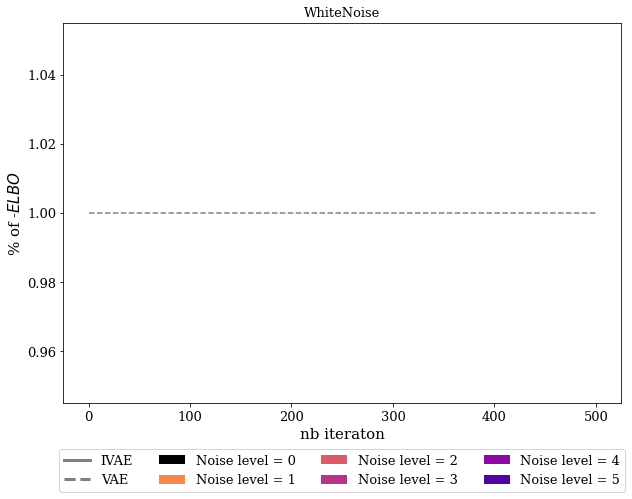

In [128]:

cmap = plt.get_cmap('plasma')
x = np.linspace(0.0, 1.0, 8)
# rgb = cm.get_cmap(plt.get_cmap('plasma'))(x)
color_list = cm.get_cmap(plt.get_cmap('plasma'))(x)
color_list = list(reversed(color_list[:6]))
# color_list = ['darkblue','slateblue', 'green', 'purple','red', 'orange']

text_size = 13
y_lim_inf = 72
beta = 1

fig, ax = plt.subplots(1, 1 ,figsize=(10,7))
nb_it = 500.0
zdim = 15.0
#svi_lr_eval = 5e-3
list_it = np.arange(0,501,25)
print(dico_config.keys())

idx_graph = 0
plots = {}
my_noise_list = ['NoNoise', 'WhiteNoise']
my_param_list = [0.2,0.4,0.6,0.8,1]
#for noise_type in dico_config.keys():
for noise_type in my_noise_list:
    if noise_type != 'NoNoise':
        idx_inf = 10
        #for idx_param, param in enumerate(my_param_list):
        #for idx_param, param in enumerate(dico_config[noise_type]['param']):
            #model_type = 'CL'
            #out_CL = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
            #             (EVAL_db['transform'] == noise_type) & \
            #             (EVAL_db['normalize_output'] == 1.0) & \
            #             (EVAL_db['param'] == param), 'path_to_results'].values[0]
            
            #if idx_param==0:
            #    print(out_CL)
            #accu_CL = torch.load(  out_CL)['accuracy']
            #accu_CL = accu_CL.cpu().numpy()
            

            #if accu_CL < y_lim_inf :

            #    accu_CL = y_lim_inf+1.5

            #    position_x = list_it[-1]+idx_inf
            #    idx_inf += 7
            #else : 
            #    position_x = list_it[-1]
            #accu_CL = 100 - accu_CL
            #ax.plot(list_it[-1], accu_CL, '*', color=color_list[idx_param], label=r'CL - $\sigma$={}'.format(param))
            #ax.plot(position_x, accu_CL, '*', color=color_list[idx_param], label=r'CL - $\sigma$={}'.format(param))
            
        ## baseline classifier
        #model_type = 'CL'
        #out_CL = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
        #     (EVAL_db['transform'] == 'NoNoise') & \
        #     (EVAL_db['normalize_output'] == 1.0), 'path_to_results'].values[0]
        #accu_CL = torch.load(  out_CL)['accuracy']
        #accu_CL = accu_CL.cpu().numpy()
        
        #accu_CL = 100-accu_CL
        
        #ax.plot(list_it[-1], accu_CL, '*', color='black', label=r'CL - NoNoise'.format(param))
        it_to_target_IVAE = []
        
        model_type = 'VAE'
        out_VAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
             (EVAL_db['model_z_dim'] == zdim) & \
             (EVAL_db['beta'] == beta) & \
             (EVAL_db['transform'] == 'NoNoise') & \
             (EVAL_db['normalize_output'] == 1.0),
             #(EVAL_db['svi_nb_it_eval'] == nb_it) & \ 
                          'path_to_results'].values
        
        ELBO_VAE = np.stack([torch.load(
                file)['ELBO'] for file in out_VAE], 0)
            #accu_VAE = 100 - accu_VAE
        ELBO_VAE = ELBO_VAE.mean(1) 
        
        
        model_type = 'IVAE'
        

        out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                 (EVAL_db['model_z_dim'] == zdim) & \
                 (EVAL_db['beta'] == beta) & \
                 (EVAL_db['transform'] == 'NoNoise') & \
                 (EVAL_db['normalize_output'] == 1.0) & \
                 #(EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                 (EVAL_db['svi_nb_it_eval'] == nb_it), 'path_to_results'].values

        ELBO_IVAE = np.stack([torch.load(file)['ELBO'] for file in out_IVAE], 0)
        
        #accu_IVAE = 100-accu_IVAE
        ELBO_IVAE = ELBO_IVAE.mean(1)
        #rel_ELBO_IVAE = ELBO_IVAE/ELBO_VAE[:,None]
        rel_ELBO_IVAE = -ELBO_IVAE #+ ELBO_VAE[:,None]
        # = ELBO_VAE[:,None]/ELBO_IVAE
        rel_ELBO_IVAE = rel_ELBO_IVAE.mean(0)
        #ELBO_IVAE_mean = rel_ELBO_IVAE.mean(0)
        #ELBO_IVAE_std = rel_ELBO_IVAE.std(0)
        x = list_it
        y = np.array(ELBO_IVAE_mean)
        
         #print(accu_IVAE.max()*0.95)
        target = rel_ELBO_IVAE.max()*1.01
        print('-ELBO', rel_ELBO_IVAE)
        print('target', target)
        
        
        
        #print(target)
        
        for idx_ele, ele in enumerate(rel_ELBO_IVAE):
            if ele >= target:
                print('here')
                idx_target = list_it[idx_ele]+1
                it_to_target_IVAE.append(idx_target)
                print('idx_target',idx_target)
                break
                    

        
        
        for idx_param, param in enumerate(my_param_list):
        #for idx_param, param in enumerate(dico_config[noise_type]['param']):
            model_type = 'VAE'
            out_VAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                     (EVAL_db['model_z_dim'] == zdim) & \
                     (EVAL_db['beta'] == beta) & \
                     (EVAL_db['transform'] == noise_type) & \
                     (EVAL_db['normalize_output'] == 1.0) & \
                     #(EVAL_db['svi_nb_it_eval'] == nb_it) & \
                     (EVAL_db['param'] == param), 
                                  'path_to_results'].values
            
        
            ELBO_VAE = np.stack([torch.load(
                file)['ELBO'] for file in out_VAE], 0)
            
            ELBO_VAE = ELBO_VAE.mean(1) 
            
            model_type = 'IVAE'
            #print(dico_config[noise_type]['lr_svi'])
            out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                     (EVAL_db['model_z_dim'] == zdim) & \
                     (EVAL_db['beta'] == beta) & \
                     (EVAL_db['transform'] == noise_type) & \
                     (EVAL_db['normalize_output'] == 1.0) & \
                     (EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                     (EVAL_db['svi_nb_it_eval'] == nb_it) & \
                     (EVAL_db['param'] == param), 'path_to_results'].values

            #accu_IVAE = np.stack([torch.load(
            #    file)['accuracy'] for file in out_IVAE], 0)
            
            ELBO_IVAE = np.stack([torch.load(
                file)['ELBO'] for file in out_IVAE], 0)
            #accu_VAE = 100 - accu_VAE
            #print(ELBO_IVAE.shape)
            #stop
            ELBO_IVAE = ELBO_IVAE.mean(1) 
            rel_ELBO_IVAE = -ELBO_IVAE #+ ELBO_VAE[:,None]
            #rel_ELBO_IVAE = ELBO_VAE[:,None]/ELBO_IVAE
            
            rel_ELBO_IVAE = rel_ELBO_IVAE.mean(0)
            #print(accu_IVAE.max()*0.95)
            target = rel_ELBO_IVAE.max()*1.01
            print('-ELBO', rel_ELBO_IVAE)
            print('target', target)
            #print(target)

            
            
            for idx_ele, ele in enumerate(rel_ELBO_IVAE):
                
                if ele >= target:
                    print('here')
                    idx_target = list_it[idx_ele]+1
                    it_to_target_IVAE.append(idx_target)
                    print('idx_target', idx_target)
                    break
                    
                    
            #rel_ELBO_IVAE = ELBO_VAE[:,None]/ELBO_IVAE
            ELBO_IVAE_mean = rel_ELBO_IVAE.mean(0)
            

                    
                    
                    
            ELBO_IVAE_std = rel_ELBO_IVAE.std(0)
            x = list_it
            y = np.array(ELBO_IVAE_mean)
            
            
            
            
            
            #accu_IVAE = 100-accu_IVAE
            #accu_IVAE_mean = accu_IVAE.mean(0)
            #accu_IVAE_std = accu_IVAE.std(0)
            #x = list_it
            #y = np.array(accu_IVAE_mean)
            

            #ax.plot(x, y, color=color_list[idx_param], label=r'IVAE - $\sigma$={}'.format(param))
            #ax.fill_between(x, (y-ELBO_IVAE_std), (y+ELBO_IVAE_std), color=color_list[idx_param], alpha=.1)
            

            #ax.plot(x, y, '--', color=color_list[idx_param], label=r'VAE - $\sigma$={}'.format(param))
            #ax.fill_between(x, (y-ELBO_VAE_std), (y+ELBO_VAE_std), color=color_list[idx_param], alpha=.1)
            
        ## baseline VAE
        
        #ax.plot(x, y, color='black', label=r'IVAE - $\sigma$={}'.format(param))
        #ax.fill_between(x, (y-ELBO_IVAE_std), (y+ELBO_IVAE_std), color='black', alpha=.1)
        
        #ax[idx_graph].set_title(r'\textbf{' + noise_type + r'}', fontsize=text_size)
        ax.set_title(noise_type, fontsize=text_size)
        
        
        #ELBO_VAE_mean = ELBO_VAE.mean(0)
        #ELBO_VAE_std = ELBO_VAE.std(0)
        #x = [list_it[0],list_it[-1]]
        #y = np.array([ELBO_VAE_mean, ELBO_VAE_mean])


        #ax.plot(x, y, '--', color='black', label=r'VAE - NoNoise')
        #ax.fill_between(x, (y-ELBO_VAE_std), (y+ELBO_VAE_std), color=color_list[idx_param], alpha=.1)
        
        #for idx_param, param in enumerate(dico_config[noise_type]['param']):
        #for idx_param, param in enumerate(my_param_list):
        #    model_type = 'PCN'

        #    out_PCN = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
        #             (EVAL_db['model_z_dim'] == zdim) & \
        #             (EVAL_db['beta'] == beta) & \
        #             (EVAL_db['transform'] == noise_type) & \
        #             (EVAL_db['normalize_output'] == 1.0) & \
#                      (EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
        #             (EVAL_db['svi_nb_it_eval'] == nb_it) & \
        #             (EVAL_db['param'] == param), 'path_to_results'].values
            
        #    accu_PCN = np.stack([torch.load(
        #        file)['accuracy'] for file in out_PCN], 0)
            #accu_PCN = 100-accu_PCN
        #    accu_PCN_mean = accu_PCN.mean(0)
        #    accu_PCN_std = accu_PCN.std(0)
            
        #    x = list_it
        #    y = np.array(accu_PCN_mean)
            
        #    ax.plot(x, y, ':', color=color_list[idx_param], alpha=1.0, label=r'PCN - $\sigma$={}'.format(param))
        #    ax.fill_between(x, (y-accu_PCN_std), (y+accu_PCN_std), color=color_list[idx_param], alpha=.05)
            
        ## baseline PCN
        #model_type = 'PCN'

        #out_PCN = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
        #         (EVAL_db['model_z_dim'] == zdim) & \
        #         (EVAL_db['beta'] == beta) & \
        #         (EVAL_db['transform'] == 'NoNoise') & \
        #         (EVAL_db['normalize_output'] == 1.0) & \
                 #(EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
        #         (EVAL_db['svi_nb_it_eval'] == nb_it), 'path_to_results'].values
        
        #accu_PCN = np.stack([torch.load(file)['accuracy'] for file in out_PCN], 0)
        #accu_PCN = 100-accu_PCN
        #accu_PCN_mean = accu_PCN.mean(0)
        #accu_PCN_std = accu_PCN.std(0)

        #x = list_it
        #y = np.array(accu_PCN_mean)
        
        #ax.plot(x, y, ':', color='black', alpha=1.0, label=r'PCN - NoNoise')
        #ax.fill_between(x, (y-accu_PCN_std), (y+accu_PCN_std), color=color_list[idx_param], alpha=.05)

        #for idx_param, param in enumerate(dico_config[noise_type]['param']):
        '''
        for idx_param, param in enumerate(my_param_list):
            model_type = 'IVAE'
            #print(dico_config[noise_type]['lr_svi'])
            out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                     (EVAL_db['model_z_dim'] == zdim) & \
                     (EVAL_db['beta'] == beta) & \
                     (EVAL_db['transform'] == noise_type) & \
                     (EVAL_db['normalize_output'] == 1.0) & \
                     (EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                     (EVAL_db['svi_nb_it_eval'] == nb_it) & \
                     (EVAL_db['param'] == param), 'path_to_results'].values

            #accu_IVAE = np.stack([torch.load(
            #    file)['accuracy'] for file in out_IVAE], 0)
            
            ELBO_IVAE = np.stack([torch.load(
                file)['ELBO'] for file in out_IVAE], 0)
            #accu_VAE = 100 - accu_VAE
            #print(ELBO_IVAE.shape)
            #stop
            ELBO_IVAE = ELBO_IVAE.mean(1) 
            ELBO_IVAE_mean = ELBO_IVAE.mean(0)
            ELBO_IVAE_std = ELBO_IVAE.std(0)
            x = list_it
            y = np.array(ELBO_IVAE_mean)
            
            
            
            
            
            #accu_IVAE = 100-accu_IVAE
            #accu_IVAE_mean = accu_IVAE.mean(0)
            #accu_IVAE_std = accu_IVAE.std(0)
            #x = list_it
            #y = np.array(accu_IVAE_mean)
            

            ax.plot(x, y, color=color_list[idx_param], label=r'IVAE - $\sigma$={}'.format(param))
            ax.fill_between(x, (y-ELBO_IVAE_std), (y+ELBO_IVAE_std), color=color_list[idx_param], alpha=.1)

        ## baseline IVAE
        model_type = 'IVAE'
        

        out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                 (EVAL_db['model_z_dim'] == zdim) & \
                 (EVAL_db['beta'] == beta) & \
                 (EVAL_db['transform'] == 'NoNoise') & \
                 (EVAL_db['normalize_output'] == 1.0) & \
                 #(EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                 (EVAL_db['svi_nb_it_eval'] == nb_it), 'path_to_results'].values

        ELBO_IVAE = np.stack([torch.load(file)['ELBO'] for file in out_IVAE], 0)
        
        #accu_IVAE = 100-accu_IVAE
        ELBO_IVAE = ELBO_IVAE.mean(1)
        ELBO_IVAE_mean = ELBO_IVAE.mean(0)
        ELBO_IVAE_std = ELBO_IVAE.std(0)
        x = list_it
        y = np.array(ELBO_IVAE_mean)

        ax.plot(x, y, color='black', label=r'IVAE - $\sigma$={}'.format(param))
        ax.fill_between(x, (y-ELBO_IVAE_std), (y+ELBO_IVAE_std), color='black', alpha=.1)
        
        #ax[idx_graph].set_title(r'\textbf{' + noise_type + r'}', fontsize=text_size)
        ax.set_title(noise_type, fontsize=text_size)

        #ax.set_ylim(1, 100)
        #ax.set_yscale('log')
        #ax.invert_yaxis()
        #ax.set_yticklabels(['100','99','90','0'])
        #ax.set_yticklabels([60,80,100])
        #ax.set_ylim(y_lim_inf,100)
        '''
        ax.tick_params(labelsize=text_size)
        
        ax.plot([list_it[0], list_it[-1]], [1,1], linestyle='--', color='grey')
        idx_graph+=1    
    
        
# setting labels
ax.set_xlabel(r'nb iteraton', fontsize=15)
ax.set_ylabel(r'% of -$ELBO$', fontsize=15)
#ax[1].set_xlabel(r'\textbf{nb iteraton}', fontsize=15)
#ax[0].set_ylabel(r'\textbf{accuracy}', fontsize=15)
#ax.arrow(505,74,0,-1,head_width=5, head_length=0.5, fc='k', ec='k')

    
legend_elements = [#Line2D([0], [0], marker='*', color='w', label='CL', markerfacecolor='grey', markersize=15),
                   Line2D([0], [0], linestyle='-',  color='grey', lw=3, label='IVAE'),
                   Line2D([0], [0], linestyle='--', color='grey', lw=3, label='VAE'),
                   #Line2D([0], [0], linestyle=':',  color='grey', lw=3, label='PCN'),
                   Patch(facecolor='black',       label='Noise level = 0'),
                   Patch(facecolor=color_list[0], label='Noise level = 1'),
                   Patch(facecolor=color_list[1], label='Noise level = 2'),
                   Patch(facecolor=color_list[2], label='Noise level = 3'),
                   Patch(facecolor=color_list[3], label='Noise level = 4'),
                   Patch(facecolor=color_list[4], label='Noise level = 5')
                  ]

ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5,-0.25), ncol=4, fontsize=text_size)


#plt.savefig('large_plot.pdf', bbox_inches='tight')





dict_keys(['NoNoise', 'Blurring', 'WhiteNoise', 'SaltPepper'])
/media/data_cifs_lrs/projects/prj_predcoding/prj_probcod_exps/2020-09-29_08-36-35_EVAL_CL/result_Blurring_1.pth
/media/data_cifs_lrs/projects/prj_predcoding/prj_probcod_exps/2020-09-29_08-36-35_EVAL_CL/result_WhiteNoise_0.2.pth
/media/data_cifs_lrs/projects/prj_predcoding/prj_probcod_exps/2020-09-29_08-36-35_EVAL_CL/result_SaltPepper_0.1.pth


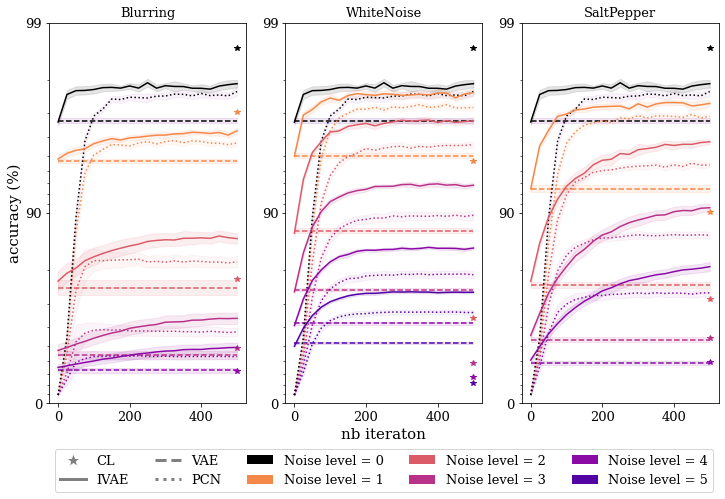

In [9]:

cmap = plt.get_cmap('plasma')
x = np.linspace(0.0, 1.0, 8)
# rgb = cm.get_cmap(plt.get_cmap('plasma'))(x)
color_list = cm.get_cmap(plt.get_cmap('plasma'))(x)
color_list = list(reversed(color_list[:6]))
# color_list = ['darkblue','slateblue', 'green', 'purple','red', 'orange']

text_size = 13

beta = 1

fig, ax = plt.subplots(1, 3 ,figsize=(12,7))
nb_it = 500.0
zdim = 15.0
#svi_lr_eval = 5e-3
list_it = np.arange(0,501,25)
print(dico_config.keys())

idx_graph = 0
plots = {}
for noise_type in dico_config.keys():
    if noise_type != 'NoNoise':
        for idx_param, param in enumerate(dico_config[noise_type]['param']):
            model_type = 'CL'
            out_CL = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                         (EVAL_db['transform'] == noise_type) & \
                         (EVAL_db['normalize_output'] == 1.0) & \
                         (EVAL_db['param'] == param), 'path_to_results'].values[0]
            
            if idx_param==0:
                print(out_CL)
            accu_CL = torch.load(  out_CL)['accuracy']
            accu_CL = accu_CL.cpu().numpy()
            accu_CL = 100 - accu_CL
            ax[idx_graph].plot(list_it[-1], accu_CL, '*', color=color_list[idx_param], label=r'CL - $\sigma$={}'.format(param))
            
        ## baseline classifier
        model_type = 'CL'
        out_CL = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
             (EVAL_db['transform'] == 'NoNoise') & \
             (EVAL_db['normalize_output'] == 1.0), 'path_to_results'].values[0]
        accu_CL = torch.load(  out_CL)['accuracy']
        accu_CL = accu_CL.cpu().numpy()
        
        accu_CL = 100-accu_CL
        
        ax[idx_graph].plot(list_it[-1], accu_CL, '*', color='black', label=r'CL - NoNoise'.format(param))
        for idx_param, param in enumerate(dico_config[noise_type]['param']):
            model_type = 'VAE'
            out_VAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                     (EVAL_db['model_z_dim'] == zdim) & \
                     (EVAL_db['beta'] == beta) & \
                     (EVAL_db['transform'] == noise_type) & \
                     (EVAL_db['normalize_output'] == 1.0) & \
                     #(EVAL_db['svi_nb_it_eval'] == nb_it) & \
                     (EVAL_db['param'] == param), 
                                  'path_to_results'].values
            
            accu_VAE = np.stack([torch.load(
                file)['accuracy'] for file in out_VAE], 0)
            accu_VAE = 100 - accu_VAE
            accu_VAE_mean = accu_VAE.mean(0)
            accu_VAE_std = accu_VAE.std(0)
            x = [list_it[0],list_it[-1]]
            y = np.array([accu_VAE_mean, accu_VAE_mean])

            ax[idx_graph].plot(x, y, '--', color=color_list[idx_param], label=r'VAE - $\sigma$={}'.format(param))
            ax[idx_graph].fill_between(x, (y-accu_VAE_std), (y+accu_VAE_std), color=color_list[idx_param], alpha=.1)
            
        ## baseline VAE
        model_type = 'VAE'
        out_VAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
             (EVAL_db['model_z_dim'] == zdim) & \
             (EVAL_db['beta'] == beta) & \
             (EVAL_db['transform'] == 'NoNoise') & \
             (EVAL_db['normalize_output'] == 1.0),
             #(EVAL_db['svi_nb_it_eval'] == nb_it) & \ 
                          'path_to_results'].values

        accu_VAE = np.stack([torch.load(
            file)['accuracy'] for file in out_VAE], 0)
        accu_VAE = 100- accu_VAE
        accu_VAE_mean = accu_VAE.mean(0)
        accu_VAE_std = accu_VAE.std(0)
        x = [list_it[0],list_it[-1]]
        y = np.array([accu_VAE_mean, accu_VAE_mean])

        ax[idx_graph].plot(x, y, '--', color='black', label=r'VAE - NoNoise')
        ax[idx_graph].fill_between(x, (y-accu_VAE_std), (y+accu_VAE_std), color=color_list[idx_param], alpha=.1)
        
        for idx_param, param in enumerate(dico_config[noise_type]['param']):
            model_type = 'PCN'

            out_PCN = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                     (EVAL_db['model_z_dim'] == zdim) & \
                     (EVAL_db['beta'] == beta) & \
                     (EVAL_db['transform'] == noise_type) & \
                     (EVAL_db['normalize_output'] == 1.0) & \
#                      (EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                     (EVAL_db['svi_nb_it_eval'] == nb_it) & \
                     (EVAL_db['param'] == param), 'path_to_results'].values
            
            accu_PCN = np.stack([torch.load(
                file)['accuracy'] for file in out_PCN], 0)
            accu_PCN = 100-accu_PCN
            accu_PCN_mean = accu_PCN.mean(0)
            accu_PCN_std = accu_PCN.std(0)
            
            x = list_it
            y = np.array(accu_PCN_mean)
            
            ax[idx_graph].plot(x, y, ':', color=color_list[idx_param], alpha=1.0, label=r'PCN - $\sigma$={}'.format(param))
            ax[idx_graph].fill_between(x, (y-accu_PCN_std), (y+accu_PCN_std), color=color_list[idx_param], alpha=.05)
            
        ## baseline PCN
        model_type = 'PCN'

        out_PCN = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                 (EVAL_db['model_z_dim'] == zdim) & \
                 (EVAL_db['beta'] == beta) & \
                 (EVAL_db['transform'] == 'NoNoise') & \
                 (EVAL_db['normalize_output'] == 1.0) & \
                 #(EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                 (EVAL_db['svi_nb_it_eval'] == nb_it), 'path_to_results'].values
        
        accu_PCN = np.stack([torch.load(file)['accuracy'] for file in out_PCN], 0)
        accu_PCN = 100-accu_PCN
        accu_PCN_mean = accu_PCN.mean(0)
        accu_PCN_std = accu_PCN.std(0)

        x = list_it
        y = np.array(accu_PCN_mean)
        
        ax[idx_graph].plot(x, y, ':', color='black', alpha=1.0, label=r'PCN - NoNoise')
        ax[idx_graph].fill_between(x, (y-accu_PCN_std), (y+accu_PCN_std), color=color_list[idx_param], alpha=.05)

        for idx_param, param in enumerate(dico_config[noise_type]['param']):
            model_type = 'IVAE'
            #print(dico_config[noise_type]['lr_svi'])
            out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                     (EVAL_db['model_z_dim'] == zdim) & \
                     (EVAL_db['beta'] == beta) & \
                     (EVAL_db['transform'] == noise_type) & \
                     (EVAL_db['normalize_output'] == 1.0) & \
                     (EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                     (EVAL_db['svi_nb_it_eval'] == nb_it) & \
                     (EVAL_db['param'] == param), 'path_to_results'].values

            accu_IVAE = np.stack([torch.load(
                file)['accuracy'] for file in out_IVAE], 0)
            accu_IVAE = 100-accu_IVAE
            accu_IVAE_mean = accu_IVAE.mean(0)
            accu_IVAE_std = accu_IVAE.std(0)
            x = list_it
            y = np.array(accu_IVAE_mean)
            

            ax[idx_graph].plot(x, y, color=color_list[idx_param], label=r'IVAE - $\sigma$={}'.format(param))
            ax[idx_graph].fill_between(x, (y-accu_IVAE_std), (y+accu_IVAE_std), color=color_list[idx_param], alpha=.1)
            
        ## baseline IVAE
        model_type = 'IVAE'

        out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                 (EVAL_db['model_z_dim'] == zdim) & \
                 (EVAL_db['beta'] == beta) & \
                 (EVAL_db['transform'] == 'NoNoise') & \
                 (EVAL_db['normalize_output'] == 1.0) & \
                 #(EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                 (EVAL_db['svi_nb_it_eval'] == nb_it), 'path_to_results'].values

        accu_IVAE = np.stack([torch.load(file)['accuracy'] for file in out_IVAE], 0)
        
        accu_IVAE = 100-accu_IVAE
        accu_IVAE_mean = accu_IVAE.mean(0)
        accu_IVAE_std = accu_IVAE.std(0)
        x = list_it
        y = np.array(accu_IVAE_mean)

        ax[idx_graph].plot(x, y, color='black', label=r'IVAE - $\sigma$={}'.format(param))
        ax[idx_graph].fill_between(x, (y-accu_IVAE_std), (y+accu_IVAE_std), color='black', alpha=.1)
        
        #ax[idx_graph].set_title(r'\textbf{' + noise_type + r'}', fontsize=text_size)
        ax[idx_graph].set_title(noise_type, fontsize=text_size)

        ax[idx_graph].set_ylim(1, 100)
        ax[idx_graph].set_yscale('log')
        ax[idx_graph].invert_yaxis()
        ax[idx_graph].set_yticklabels(['100','99','90','0'])
        
        ax[idx_graph].tick_params(labelsize=text_size)
        
        idx_graph+=1    
    
        
# setting labels
ax[1].set_xlabel(r'nb iteraton', fontsize=15)
ax[0].set_ylabel(r'accuracy (%)', fontsize=15)
#ax[1].set_xlabel(r'\textbf{nb iteraton}', fontsize=15)
#ax[0].set_ylabel(r'\textbf{accuracy}', fontsize=15)


    
legend_elements = [Line2D([0], [0], marker='*', color='w', label='CL', markerfacecolor='grey', markersize=15),
                   Line2D([0], [0], linestyle='-',  color='grey', lw=3, label='IVAE'),
                   Line2D([0], [0], linestyle='--', color='grey', lw=3, label='VAE'),
                   Line2D([0], [0], linestyle=':',  color='grey', lw=3, label='PCN'),
                   Patch(facecolor='black',       label='Noise level = 0'),
                   Patch(facecolor=color_list[0], label='Noise level = 1'),
                   Patch(facecolor=color_list[1], label='Noise level = 2'),
                   Patch(facecolor=color_list[2], label='Noise level = 3'),
                   Patch(facecolor=color_list[3], label='Noise level = 4'),
                   Patch(facecolor=color_list[4], label='Noise level = 5')
                  ]

ax[1].legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5,-0.25), ncol=5, fontsize=text_size)

#plt.savefig('large_plot.pdf', bbox_inches='tight')


dict_keys(['NoNoise', 'Blurring', 'WhiteNoise', 'SaltPepper'])
Blurring
WhiteNoise
SaltPepper


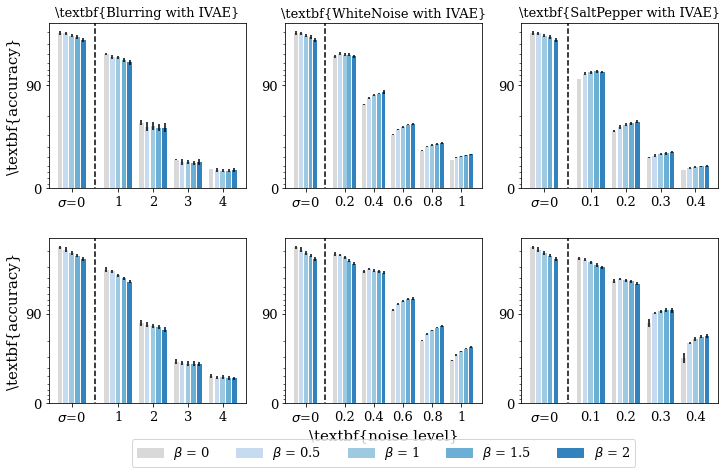

In [7]:
text_size = 13
cmap = plt.cm.get_cmap('tab20c')
all_color = [cmap.colors[19], cmap.colors[3], cmap.colors[2], cmap.colors[1], cmap.colors[0]]
zdim=15.0
beta_list = [0,0.5,1,1.5,2]
nb_it = 500.0

fig, ax = plt.subplots(2,3,figsize=(12,7))
plt.tick_params(
            axis='x',
            which='both',
            bottom=False,
            top=False,
            labelbottom=True)
i = 0
print(dico_config.keys())
idx_noise=-1

all_bars = []
for noise_type in dico_config.keys():
    
    if noise_type != 'NoNoise':
        
        ax[0, idx_noise].set_yscale('log')
        ax[0, idx_noise].invert_yaxis()

        idx_noise += 1
        param_list = dico_config[noise_type]['param']
        tick_position = [2] + [10 +  6*i for i in range(len(param_list))]
        i=0
        print(noise_type)
            
        for idx_beta, beta in enumerate(beta_list):
            model_type = 'VAE'
            out_VAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
             (EVAL_db['model_z_dim'] == zdim) & \
             (EVAL_db['beta'] == beta) & \
             (EVAL_db['transform'] == 'NoNoise') & \
             (EVAL_db['normalize_output'] == 1.0),
             #(EVAL_db['svi_nb_it_eval'] == nb_it) & \
                          'path_to_results'].values
            
            accu_VAE = np.stack([torch.load(
                file)['accuracy'] for file in out_VAE], 0)

            accu_VAE_mean = accu_VAE.mean(0)
            accu_VAE_std = accu_VAE.std(0)
            bars = ax[0, idx_noise].bar(i, -accu_VAE_mean, color=all_color[idx_beta], bottom=100, label=r'$\beta$ = {0}'.format(beta), yerr=accu_VAE_std)
        
            all_bars.append(bars)
            i=i+1
        i=i+1
        ax[0, idx_noise].vlines(i, 0,100, linestyles='dashed', color='black')
        i=i+2
        for idx_param, param in enumerate(param_list):
            for idx_beta, beta in enumerate(beta_list):
                model_type = 'VAE'
                out_VAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                         (EVAL_db['model_z_dim'] == zdim) & \
                         (EVAL_db['beta'] == beta) & \
                         (EVAL_db['transform'] == noise_type) & \
                         (EVAL_db['normalize_output'] == 1.0) & \
                         #(EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                         #(EVAL_db['svi_lr_eval'] == 1e-2) & \
                         (EVAL_db['svi_nb_it_eval'] == nb_it) & \
                         (EVAL_db['param'] == param), 'path_to_results'].values
            
                accu_VAE = np.stack([torch.load(
                    file)['accuracy'] for file in out_VAE], 0)

                accu_VAE_mean = accu_VAE.mean(0)
                accu_VAE_std = accu_VAE.std(0)
                bars = ax[0, idx_noise].bar(i, -accu_VAE_mean, color=all_color[idx_beta], bottom=100, label=r'$\beta$ = {0}'.format(beta), yerr=accu_VAE_std)
                
                all_bars.append(bars)

                i = i+1
            i = i+1

        ax[0,idx_noise].set_xticks(tick_position)
        ax[0,idx_noise].set_title(noise_type + ' with VAE', fontsize=text_size)
        ax[0,idx_noise].set_xticklabels([r'$\sigma$=0']+ [str(param) for param in param_list ], fontsize=text_size)
        ax[0,idx_noise].tick_params(labelsize=text_size)
    

    
        ###########################################################################################################################
        ###########################################################################################################################
        
        ax[1, idx_noise].set_yscale('log')
        ax[1, idx_noise].invert_yaxis()
        
        i=0
        for idx_beta, beta in enumerate(beta_list):
            model_type = 'IVAE'
            #print(dico_config[noise_type]['lr_svi'])
            out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                 (EVAL_db['model_z_dim'] == zdim) & \
                 (EVAL_db['beta'] == beta) & \
                 (EVAL_db['transform'] == 'NoNoise') & \
                 (EVAL_db['normalize_output'] == 1.0) & \
                 #(EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                 (EVAL_db['svi_nb_it_eval'] == nb_it), 'path_to_results'].values
            
            accu_VAE = np.stack([torch.load(
                file)['accuracy'] for file in out_IVAE], 0)

            accu_VAE_mean = accu_VAE.mean(0)
            accu_VAE_std = accu_VAE.std(0)
            
            bars = ax[1, idx_noise].bar(i, -accu_VAE_mean[-1], color=all_color[idx_beta], bottom=100, label=r'$\beta$ = {0}'.format(beta), yerr=accu_VAE_std[-1])
            
            all_bars.append(bars)
            i=i+1
        i=i+1
        ax[1, idx_noise].vlines(i, 0,100, linestyles='dashed', color='black')
        i=i+2
        for idx_param, param in enumerate(param_list):
            for idx_beta, beta in enumerate(beta_list):
                model_type = 'IVAE'
                out_IVAE = EVAL_db.loc[(EVAL_db['model_type'] == model_type) & \
                         (EVAL_db['model_z_dim'] == zdim) & \
                         (EVAL_db['beta'] == beta) & \
                         (EVAL_db['transform'] == noise_type) & \
                         (EVAL_db['normalize_output'] == 1.0) & \
                         #(EVAL_db['svi_lr_eval'] == dico_config[noise_type]['lr_svi']) & \
                         (EVAL_db['svi_nb_it_eval'] == nb_it) & \
                         (EVAL_db['param'] == param), 'path_to_results'].values
            
                accu_VAE = np.stack([torch.load(
                    file)['accuracy'] for file in out_IVAE], 0)

                accu_VAE_mean = accu_VAE.mean(0)
                accu_VAE_std = accu_VAE.std(0)
                bars = ax[1, idx_noise].bar(i, -accu_VAE_mean[-1], color=all_color[idx_beta], bottom=100, label=r'$\beta$ = {0}'.format(beta), yerr=accu_VAE_std[-1])

                all_bars.append(bars)
                i = i+1
            i = i+1
        ax[1,idx_noise].set_xticks(tick_position)
        ax[1,idx_noise].set_xticklabels([r'$\sigma$=0']+ [str(param) for param in param_list ], fontsize=text_size)
        ax[1,idx_noise].tick_params(labelsize=text_size)
        
        # set title
        ax[0,idx_noise].set_title(r'\textbf{' + noise_type + r' with IVAE}', fontsize=text_size)
        

ax[0,0].set_yticklabels(['100','99','90','0'])
ax[0,1].set_yticklabels(['100','99','90','0'])
ax[0,2].set_yticklabels(['100','99','90','0'])
ax[1,0].set_yticklabels(['100','99','90','0'])
ax[1,1].set_yticklabels(['100','99','90','0'])
ax[1,2].set_yticklabels(['100','99','90','0'])

ax[1,1].set_xlabel(r'\textbf{noise level}', fontsize=15)

ax[0,0].set_ylabel(r'\textbf{accuracy}', fontsize=15)
ax[1,0].set_ylabel(r'\textbf{accuracy}', fontsize=15)



## just for legend
patches = []
for idx_beta, color in enumerate(all_color):
    patches.append(mpatches.Patch(color=color, label=r'$\beta$ = {0}'.format(beta_list[idx_beta])))
out = plt.legend(handles=patches, fontsize=text_size, loc='center', bbox_to_anchor=(-0.7,-0.3), ncol=5)

plt.subplots_adjust(hspace=0.3)
#plt.savefig('beta_plot.pdf', bbox_inches='tight')
